# CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from uuid import uuid4

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Đọc dữ liệu đã tiền xử lý
df = pd.read_csv('china_scaled.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Mẫu 5 hàng đầu tiên:")
print(df.head())
print("\nThông tin dữ liệu:")
print(df.info())

# Chọn đặc trưng và biến mục tiêu
features = [col for col in df.columns if col not in ['Effort']]
X = df[features].values
y = df['Effort'].values  

# Tăng cường dữ liệu bằng nhiễu Gaussian
def add_gaussian_noise(X, noise_factor=0.05):
    noise = np.random.normal(loc=0, scale=noise_factor, size=X.shape)
    return X + noise

X_augmented = X.copy()
y_augmented = y.copy()
for _ in range(2):  # Tạo thêm 2 bản sao với nhiễu
    X_noisy = add_gaussian_noise(X, noise_factor=0.05)
    X_augmented = np.vstack((X_augmented, X_noisy))
    y_augmented = np.hstack((y_augmented, y))

print("\n=== Sau khi tăng cường dữ liệu bằng nhiễu Gaussian ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Reshape dữ liệu thành dạng (samples, features, 1) cho Conv1D
X_augmented = X_augmented.reshape(X_augmented.shape[0], X_augmented.shape[1], 1)

print("\n=== Kích thước dữ liệu sau reshape ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)

print(f"\n✅ Kích thước dữ liệu CNN:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình CNN với Conv1D, BatchNormalization, GlobalAveragePooling1D
def build_cnn_model(filters=8, kernel_size=2, l2_reg=0.01, dense_units=16, dropout_rate=0.3, learning_rate=0.001):
    l2_reg = max(l2_reg, 0.001)
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters, kernel_size, activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Conv1D(filters, kernel_size, activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        GlobalAveragePooling1D(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số
param_bounds = {
    'filters': (4, 32),
    'kernel_size': (1, 3),
    'l2_reg': (0.001, 0.1),
    'dense_units': (8, 64),
    'dropout_rate': (0.2, 0.5),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 64),
    'epochs': (50, 150)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['filters'][0], param_bounds['filters'][1] + 1),
        np.random.randint(param_bounds['kernel_size'][0], param_bounds['kernel_size'][1] + 1),
        np.random.uniform(param_bounds['l2_reg'][0], param_bounds['l2_reg'][1]),
        np.random.randint(param_bounds['dense_units'][0], param_bounds['dense_units'][1] + 1),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'filters': int(particle[0]),
        'kernel_size': int(particle[1]),
        'l2_reg': particle[2],
        'dense_units': int(particle[3]),
        'dropout_rate': particle[4],
        'learning_rate': particle[5],
        'batch_size': int(particle[6]),
        'epochs': int(particle[7])
    }
    # Đảm bảo l2_reg không âm
    params['l2_reg'] = max(params['l2_reg'], 0.001)
    params['l2_reg'] = min(params['l2_reg'], param_bounds['l2_reg'][1])  # Giới hạn trên
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_cnn_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_cnn(num_particles=10, max_iter=15):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            # Đảm bảo l2_reg không âm và trong giới hạn
            particles[i][2] = max(particles[i][2], param_bounds['l2_reg'][0])
            particles[i][2] = min(particles[i][2], param_bounds['l2_reg'][1])
            particles[i][4] = np.clip(particles[i][4], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_cnn(num_particles=10, max_iter=15)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_cnn_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores_optimal = []
history = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/5")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                            validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")

print(f"\n📊 RMSE trung bình qua 5 folds: {np.mean(rmse_scores_optimal):.4f}")

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá trên giá trị đã scale
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]

    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))

    if np.sum(y_test_boot > 0) > 0:
        bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
        bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
        bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
        bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))
    else:
        bootstrap_metrics['mape'].append(np.nan)
        bootstrap_metrics['mmre'].append(np.nan)
        bootstrap_metrics['mdmre'].append(np.nan)
        bootstrap_metrics['pred25'].append(np.nan)

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.mean(bootstrap_metrics['mape']):.2f}% ± {np.std(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.mean(bootstrap_metrics['mmre']):.4f} ± {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.mean(bootstrap_metrics['mdmre']):.4f} ± {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.mean(bootstrap_metrics['pred25']):.2f}% ± {np.std(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.mean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.std(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.mean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.std(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.mean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.std(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.mean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.std(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('cnn_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'cnn_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('cnn_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'cnn_visualization_results_scaled.png'")

=== Kiểm tra dữ liệu ===
Kích thước: (499, 29)
Các cột: ['ID', 'AFP', 'Input', 'Output', 'Enquiry', 'File', 'Interface', 'Added', 'Changed', 'Deleted', 'PDR_AFP', 'PDR_UFP', 'NPDR_AFP', 'NPDU_UFP', 'Resource', 'Dev.Type', 'Duration', 'N_effort', 'Effort', 'TotalComponents', 'EffortPerFP', 'EffortPerMonth', 'ChangeRatio', 'TotalChanges', 'Log_AFP', 'Log_Effort', 'Log_N_effort', 'Log_TotalComponents', 'Log_EffortPerMonth']
Mẫu 5 hàng đầu tiên:
   ID       AFP     Input    Output   Enquiry      File  Interface     Added  \
0   1  2.086876  1.249152  0.662281  2.643433  0.175024  -0.285260  1.377118   
1   2 -0.220010 -0.325405 -0.495815 -0.556426  0.484459   0.197344 -0.373161   
2   3 -0.584788 -0.292473 -0.364625 -0.319048 -0.234383   0.126719 -0.238061   
3   4 -0.247030 -0.033134 -0.387244 -0.508950 -0.248664  -0.285260 -0.351449   
4   5 -0.111927 -0.152512 -0.513910  1.257144 -0.339115  -0.285260 -0.434681   

    Changed   Deleted  ...  TotalComponents  EffortPerFP  EffortPerMonth 

# MLP



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from uuid import uuid4

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Đọc dữ liệu đã tiền xử lý
df = pd.read_csv('china_scaled.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Mẫu 5 hàng đầu tiên:")
print(df.head())
print("\nThông tin dữ liệu:")
print(df.info())

# Chọn đặc trưng và biến mục tiêu
features = [col for col in df.columns if col not in ['Effort']]
X = df[features].values
y = df['Effort'].values  # Sử dụng Effort đã được scale từ file test.csv

# Tăng cường dữ liệu bằng nhiễu Gaussian
def add_gaussian_noise(X, noise_factor=0.05):
    noise = np.random.normal(loc=0, scale=noise_factor, size=X.shape)
    return X + noise

X_augmented = X.copy()
y_augmented = y.copy()
for _ in range(2):  # Tạo thêm 2 bản sao với nhiễu
    X_noisy = add_gaussian_noise(X, noise_factor=0.05)
    X_augmented = np.vstack((X_augmented, X_noisy))
    y_augmented = np.hstack((y_augmented, y))

print("\n=== Sau khi tăng cường dữ liệu bằng nhiễu Gaussian ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Không cần reshape cho MLP vì MLP không yêu cầu dữ liệu 3D
print("\n=== Kích thước dữ liệu sau tăng cường ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu MLP:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình MLP với Dense, BatchNormalization, Dropout
def build_mlp_model(hidden_layers=2, units_per_layer=32, l2_reg=0.01, dropout_rate=0.3, learning_rate=0.001):
    # Đảm bảo l2_reg không âm
    l2_reg = max(l2_reg, 0.001)
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    # Thêm các tầng ẩn
    for _ in range(int(hidden_layers)):
        model.add(Dense(int(units_per_layer), activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Tầng đầu ra
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số cho MLP
param_bounds = {
    'hidden_layers': (1, 4),  # Số tầng ẩn
    'units_per_layer': (16, 128),  # Số đơn vị mỗi tầng
    'l2_reg': (0.001, 0.1),
    'dropout_rate': (0.2, 0.5),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 64),
    'epochs': (50, 150)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['hidden_layers'][0], param_bounds['hidden_layers'][1] + 1),
        np.random.randint(param_bounds['units_per_layer'][0], param_bounds['units_per_layer'][1] + 1),
        np.random.uniform(param_bounds['l2_reg'][0], param_bounds['l2_reg'][1]),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'hidden_layers': int(particle[0]),
        'units_per_layer': int(particle[1]),
        'l2_reg': particle[2],
        'dropout_rate': particle[3],
        'learning_rate': particle[4],
        'batch_size': int(particle[5]),
        'epochs': int(particle[6])
    }
    # Đảm bảo l2_reg không âm
    params['l2_reg'] = max(params['l2_reg'], 0.001)
    params['l2_reg'] = min(params['l2_reg'], param_bounds['l2_reg'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_mlp_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                  validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_mlp(num_particles=10, max_iter=15):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            # Đảm bảo l2_reg không âm và trong giới hạn
            particles[i][2] = max(particles[i][2], param_bounds['l2_reg'][0])
            particles[i][2] = min(particles[i][2], param_bounds['l2_reg'][1])
            particles[i][3] = np.clip(particles[i][3], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_mlp(num_particles=10, max_iter=15)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_mlp_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores_optimal = []
history = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/5")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                               validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")

print(f"\n📊 RMSE trung bình qua 5 folds: {np.mean(rmse_scores_optimal):.4f}")

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá trên giá trị đã scale
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))

    if np.sum(y_test_boot > 0) > 0:
        bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
        bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
        bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
        bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))
    else:
        bootstrap_metrics['mape'].append(np.nan)
        bootstrap_metrics['mmre'].append(np.nan)
        bootstrap_metrics['mdmre'].append(np.nan)
        bootstrap_metrics['pred25'].append(np.nan)

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.mean(bootstrap_metrics['mape']):.2f}% ± {np.std(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.mean(bootstrap_metrics['mmre']):.4f} ± {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.mean(bootstrap_metrics['mdmre']):.4f} ± {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.mean(bootstrap_metrics['pred25']):.2f}% ± {np.std(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.mean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.std(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.mean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.std(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.mean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.std(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.mean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.std(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('mlp_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'mlp_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('mlp_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'mlp_visualization_results_scaled.png'")

=== Kiểm tra dữ liệu ===
Kích thước: (499, 29)
Các cột: ['ID', 'AFP', 'Input', 'Output', 'Enquiry', 'File', 'Interface', 'Added', 'Changed', 'Deleted', 'PDR_AFP', 'PDR_UFP', 'NPDR_AFP', 'NPDU_UFP', 'Resource', 'Dev.Type', 'Duration', 'N_effort', 'Effort', 'TotalComponents', 'EffortPerFP', 'EffortPerMonth', 'ChangeRatio', 'TotalChanges', 'Log_AFP', 'Log_Effort', 'Log_N_effort', 'Log_TotalComponents', 'Log_EffortPerMonth']
Mẫu 5 hàng đầu tiên:
   ID       AFP     Input    Output   Enquiry      File  Interface     Added  \
0   1  2.086876  1.249152  0.662281  2.643433  0.175024  -0.285260  1.377118   
1   2 -0.220010 -0.325405 -0.495815 -0.556426  0.484459   0.197344 -0.373161   
2   3 -0.584788 -0.292473 -0.364625 -0.319048 -0.234383   0.126719 -0.238061   
3   4 -0.247030 -0.033134 -0.387244 -0.508950 -0.248664  -0.285260 -0.351449   
4   5 -0.111927 -0.152512 -0.513910  1.257144 -0.339115  -0.285260 -0.434681   

    Changed   Deleted  ...  TotalComponents  EffortPerFP  EffortPerMonth 

# LSTM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from uuid import uuid4

# Thiết lập seed để tái lập
np.random.seed(42)
tf.random.set_seed(42)

# Hàm tính các chỉ số đánh giá
def calculate_mape(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_mmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_mdmre(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

def calculate_pred25(y_true, y_pred):
    mask = y_true > 0
    if np.sum(mask) == 0:
        return np.nan
    mre = np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    return np.mean(mre <= 0.25) * 100

# Đọc dữ liệu đã tiền xử lý
df = pd.read_csv('china_scaled.csv')

# Kiểm tra dữ liệu
print("=== Kiểm tra dữ liệu ===")
print("Kích thước:", df.shape)
print("Các cột:", df.columns.tolist())
print("Mẫu 5 hàng đầu tiên:")
print(df.head())
print("\nThông tin dữ liệu:")
print(df.info())

# Chọn đặc trưng và biến mục tiêu
features = [col for col in df.columns if col not in ['Effort']]
X = df[features].values
y = df['Effort'].values  # Sử dụng Effort đã được scale từ file test.csv

# Tăng cường dữ liệu bằng nhiễu Gaussian
def add_gaussian_noise(X, noise_factor=0.05):
    noise = np.random.normal(loc=0, scale=noise_factor, size=X.shape)
    return X + noise

X_augmented = X.copy()
y_augmented = y.copy()
for _ in range(2):  # Tạo thêm 2 bản sao với nhiễu
    X_noisy = add_gaussian_noise(X, noise_factor=0.05)
    X_augmented = np.vstack((X_augmented, X_noisy))
    y_augmented = np.hstack((y_augmented, y))

print("\n=== Sau khi tăng cường dữ liệu bằng nhiễu Gaussian ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Reshape dữ liệu thành dạng (samples, timesteps, features) cho LSTM
# Giả định: mỗi đặc trưng là một timestep, features=1
n_timesteps = X_augmented.shape[1]
X_augmented = X_augmented.reshape(X_augmented.shape[0], n_timesteps, 1)

print("\n=== Kích thước dữ liệu sau reshape cho LSTM ===")
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.15, random_state=42)

print(f"\n✅ Kích thước dữ liệu LSTM:")
print(f" - X_train: {X_train.shape}")
print(f" - X_test : {X_test.shape}")

# Xây dựng mô hình LSTM
def build_lstm_model(units=50, l2_reg=0.01, dropout_rate=0.3, learning_rate=0.001):
    # Đảm bảo l2_reg không âm
    l2_reg = max(l2_reg, 0.001)
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units, return_sequences=False, kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(units // 2, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# Không gian siêu tham số cho LSTM
param_bounds = {
    'units': (16, 128),  # Số đơn vị trong tầng LSTM
    'l2_reg': (0.001, 0.1),
    'dropout_rate': (0.2, 0.5),
    'learning_rate': (1e-4, 1e-2),
    'batch_size': (16, 64),
    'epochs': (50, 150)
}

# Hàm mã hóa & giải mã particle
def random_particle():
    return np.array([
        np.random.randint(param_bounds['units'][0], param_bounds['units'][1] + 1),
        np.random.uniform(param_bounds['l2_reg'][0], param_bounds['l2_reg'][1]),
        np.random.uniform(param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1]),
        np.random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
        np.random.randint(param_bounds['batch_size'][0], param_bounds['batch_size'][1] + 1),
        np.random.randint(param_bounds['epochs'][0], param_bounds['epochs'][1] + 1)
    ])

def decode_particle(particle):
    params = {
        'units': int(particle[0]),
        'l2_reg': particle[1],
        'dropout_rate': particle[2],
        'learning_rate': particle[3],
        'batch_size': int(particle[4]),
        'epochs': int(particle[5])
    }
    # Đảm bảo l2_reg không âm
    params['l2_reg'] = max(params['l2_reg'], 0.001)
    params['l2_reg'] = min(params['l2_reg'], param_bounds['l2_reg'][1])
    return params

# Hàm fitness cho PSO
def fitness_function(particle):
    params = decode_particle(particle)
    model = build_lstm_model(**{k: v for k, v in params.items() if k != 'batch_size' and k != 'epochs'})
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'], 
                  validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Triển khai PSO
def run_pso_lstm(num_particles=10, max_iter=15):
    dim = len(param_bounds)
    bounds_array = np.array(list(param_bounds.values()))
    
    particles = [random_particle() for _ in range(num_particles)]
    velocities = [np.zeros(dim) for _ in range(num_particles)]
    
    p_best_positions = particles.copy()
    p_best_scores = [fitness_function(p) for p in particles]
    
    g_best_index = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_index]
    g_best_score = p_best_scores[g_best_index]
    
    w, c1, c2 = 0.5, 1.5, 1.5
    
    for iter in range(max_iter):
        print(f"\n🔁 Iteration {iter + 1}/{max_iter}")
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (p_best_positions[i] - particles[i])
                + c2 * r2 * (g_best_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], bounds_array[:, 0], bounds_array[:, 1])
            # Đảm bảo l2_reg không âm và trong giới hạn
            particles[i][1] = max(particles[i][1], param_bounds['l2_reg'][0])
            particles[i][1] = min(particles[i][1], param_bounds['l2_reg'][1])
            particles[i][2] = np.clip(particles[i][2], param_bounds['dropout_rate'][0], param_bounds['dropout_rate'][1])
            
            score = fitness_function(particles[i])
            
            if score < p_best_scores[i]:
                p_best_scores[i] = score
                p_best_positions[i] = particles[i]
                
            if score < g_best_score:
                g_best_score = score
                g_best_position = particles[i]
                print(f"✅ Cập nhật g_best: Score = {g_best_score:.4f}")
    
    return g_best_position, g_best_score

# Chạy PSO
print("🚀 Chạy PSO để tìm siêu tham số tối ưu...")
best_particle, best_score = run_pso_lstm(num_particles=10, max_iter=15)
best_params = decode_particle(best_particle)
print(f"🏆 Siêu tham số tốt nhất: {best_params}")
print(f"📉 Score tốt nhất: {best_score:.4f}")

# Huấn luyện mô hình tối ưu
model_optimal = build_lstm_model(**{k: v for k, v in best_params.items() if k != 'batch_size' and k != 'epochs'})
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores_optimal = []
history = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n📂 Fold {fold + 1}/5")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    history = model_optimal.fit(X_tr, y_tr, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                               validation_split=0.2, verbose=0, callbacks=[early_stopping, reduce_lr])
    y_pred = model_optimal.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores_optimal.append(rmse)
    print(f"✅ Fold {fold + 1} RMSE: {rmse:.4f}")

print(f"\n📊 RMSE trung bình qua 5 folds: {np.mean(rmse_scores_optimal):.4f}")

# Đánh giá trên tập test
y_pred = model_optimal.predict(X_test, verbose=0).flatten()

# Tính các chỉ số đánh giá trên giá trị đã scale
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    if np.sum(y_test_boot > 0) > 0:
        bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
        bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
        bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
        bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))
    else:
        bootstrap_metrics['mape'].append(np.nan)
        bootstrap_metrics['mmre'].append(np.nan)
        bootstrap_metrics['mdmre'].append(np.nan)
        bootstrap_metrics['pred25'].append(np.nan)

# In kết quả
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.mean(bootstrap_metrics['mape']):.2f}% ± {np.std(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.mean(bootstrap_metrics['mmre']):.4f} ± {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.mean(bootstrap_metrics['mdmre']):.4f} ± {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.mean(bootstrap_metrics['pred25']):.2f}% ± {np.std(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.mean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.std(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.mean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.std(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.mean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.std(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.mean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.std(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('lstm_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'lstm_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('lstm_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'lstm_visualization_results_scaled.png'")

=== Kiểm tra dữ liệu ===
Kích thước: (499, 29)
Các cột: ['ID', 'AFP', 'Input', 'Output', 'Enquiry', 'File', 'Interface', 'Added', 'Changed', 'Deleted', 'PDR_AFP', 'PDR_UFP', 'NPDR_AFP', 'NPDU_UFP', 'Resource', 'Dev.Type', 'Duration', 'N_effort', 'Effort', 'TotalComponents', 'EffortPerFP', 'EffortPerMonth', 'ChangeRatio', 'TotalChanges', 'Log_AFP', 'Log_Effort', 'Log_N_effort', 'Log_TotalComponents', 'Log_EffortPerMonth']
Mẫu 5 hàng đầu tiên:
   ID       AFP     Input    Output   Enquiry      File  Interface     Added  \
0   1  2.086876  1.249152  0.662281  2.643433  0.175024  -0.285260  1.377118   
1   2 -0.220010 -0.325405 -0.495815 -0.556426  0.484459   0.197344 -0.373161   
2   3 -0.584788 -0.292473 -0.364625 -0.319048 -0.234383   0.126719 -0.238061   
3   4 -0.247030 -0.033134 -0.387244 -0.508950 -0.248664  -0.285260 -0.351449   
4   5 -0.111927 -0.152512 -0.513910  1.257144 -0.339115  -0.285260 -0.434681   

    Changed   Deleted  ...  TotalComponents  EffortPerFP  EffortPerMonth 

# RFBN

Original dataset shape: (499, 29)
Checking for NaN in dataset:
ID                     0
AFP                    0
Input                  0
Output                 0
Enquiry                0
File                   0
Interface              0
Added                  0
Changed                0
Deleted                0
PDR_AFP                0
PDR_UFP                0
NPDR_AFP               0
NPDU_UFP               0
Resource               0
Dev.Type               0
Duration               0
N_effort               0
Effort                 0
TotalComponents        0
EffortPerFP            0
EffortPerMonth         0
ChangeRatio            0
TotalChanges           0
Log_AFP                0
Log_Effort             0
Log_N_effort           0
Log_TotalComponents    0
Log_EffortPerMonth     0
dtype: int64
NaN percentage (0.00%) is low, dropping rows with NaN...
Checking for infinite values in dataset:


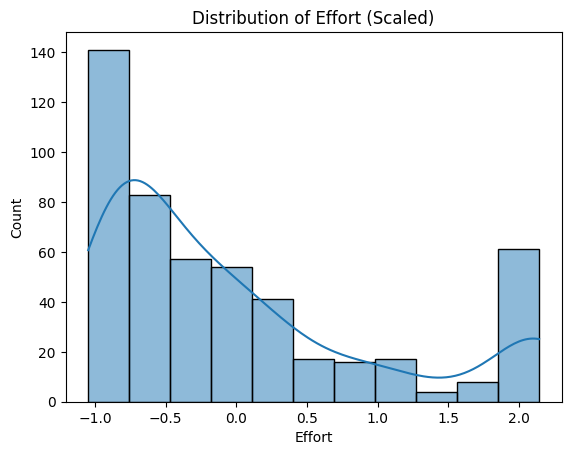

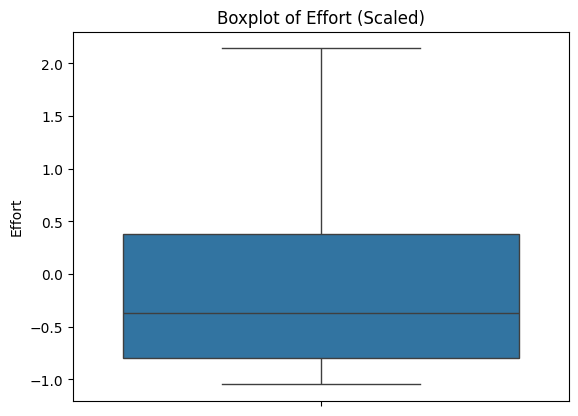

Dataset shape after removing outliers: (499, 29)
Dataset shape after removing small Effort values: (179, 29)

Columns to drop: ['ID', 'ChangeRatio', 'Interface', 'Resource', 'Deleted', 'Changed']
Number of columns to drop: 6
Remaining columns: 22 features
Dataset shape after dropping: (179, 23)
Reduced to 7 features after PCA


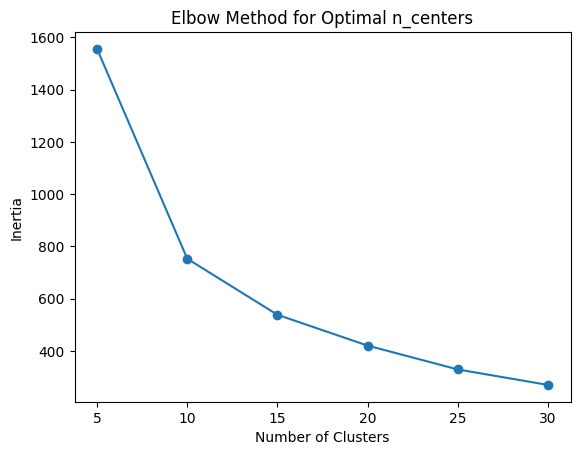

Optimal n_centers: 5
Initial sigma: 4.805100732221869

Best params: learning_rate=0.01, l2_reg=0.001, sigma=4.624347232896992
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.7793 - mae: 1.4630 - val_loss: 0.8549 - val_mae: 0.6826
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2004 - mae: 0.8646 - val_loss: 0.6328 - val_mae: 0.6828
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8790 - mae: 0.8170 - val_loss: 0.7853 - val_mae: 0.7885
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9058 - mae: 0.8451 - val_loss: 0.5880 - val_mae: 0.6640
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7904 - mae: 0.7468 - val_loss: 0.5669 - val_mae: 0.6533
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7666 - mae: 0.7847 - val_loss: 0.6612 - val_mae: 0.7312
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7100 - mae: 0.7693 - val_loss: 0.5639 - val_mae: 0.6633
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7682 - mae: 0.784

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Sequential
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Định nghĩa các hàm tính toán chỉ số
def calculate_mape(y_true, y_pred):
    relative_errors = np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-3))
    return np.clip(np.mean(relative_errors) * 100, 0, 1000)

def calculate_mmre(y_true, y_pred):
    relative_errors = np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-3))
    return np.clip(np.mean(relative_errors), 0, 1000)

def calculate_mdmre(y_true, y_pred):
    relative_errors = np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-3))
    return np.clip(np.median(relative_errors), 0, 1000)

def calculate_pred25(y_true, y_pred):
    relative_errors = np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-3))
    return np.mean(relative_errors <= 0.25) * 100

# Đọc dataset
df = pd.read_csv('china_scaled.csv')
print(f"Original dataset shape: {df.shape}")

# Kiểm tra và xử lý NaN
print("Checking for NaN in dataset:")
nan_counts = df.isna().sum()
print(nan_counts)
nan_percentage = nan_counts.sum() / (df.shape[0] * df.shape[1]) * 100
if nan_percentage < 5:
    print(f"NaN percentage ({nan_percentage:.2f}%) is low, dropping rows with NaN...")
    df = df.dropna()
else:
    print(f"NaN percentage ({nan_percentage:.2f}%) is high, filling with median...")
    df = df.fillna(df.median(numeric_only=True))

# Kiểm tra giá trị vô cực
print("Checking for infinite values in dataset:")
if np.any(np.isinf(df.values)):
    print("Found infinite values, replacing with max finite value...")
    df = df.replace([np.inf, -np.inf], np.nan).fillna(df.max(numeric_only=True))

# Kiểm tra phân bố Effort
sns.histplot(df['Effort'], kde=True)
plt.title('Distribution of Effort (Scaled)')
plt.show()

# Kiểm tra ngoại lai trong Effort
sns.boxplot(y=df['Effort'])
plt.title('Boxplot of Effort (Scaled)')
plt.show()

# Loại bỏ ngoại lai
q1, q3 = np.percentile(df['Effort'], [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['Effort'] >= lower_bound) & (df['Effort'] <= upper_bound)]
print(f"Dataset shape after removing outliers: {df.shape}")

# Loại bỏ Effort quá nhỏ
df = df[df['Effort'] >= 1e-3]
print(f"Dataset shape after removing small Effort values: {df.shape}")

# Xử lý giá trị âm trong Effort
y = df['Effort'].values
if (y < 0).any():
    print("Found negative values in Effort, replacing with 0...")
    y = np.clip(y, 0, None)

# Bước 1: Xác định cột nên drop
cols_to_drop = ['ID', 'ChangeRatio', 'Interface', 'Resource', 'Deleted', 'Changed']
print(f"\nColumns to drop: {cols_to_drop}")
print(f"Number of columns to drop: {len(cols_to_drop)}")
print(f"Remaining columns: {df.shape[1] - 1 - len(cols_to_drop)} features")

# Drop cột
df_dropped = df.drop(columns=cols_to_drop)
print(f"Dataset shape after dropping: {df_dropped.shape}")

# Chuẩn bị dữ liệu
X = df_dropped.drop(columns=['Effort']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Bước 2: Giảm chiều bằng PCA
pca = PCA(n_components=0.95)  # Giữ 95% phương sai
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Reduced to {X_train_pca.shape[1]} features after PCA")

# Bước 3: Elbow Method để chọn n_centers
inertias = []
K = range(5, 31, 5)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal n_centers')
plt.show()

optimal_n_centers = K[np.argmin(np.diff(inertias))]
print(f"Optimal n_centers: {optimal_n_centers}")

# Tính sigma khởi tạo
kmeans = KMeans(n_clusters=optimal_n_centers, random_state=42).fit(X_train_pca)
centers = kmeans.cluster_centers_
distances = euclidean_distances(centers)
sigma_init = np.mean(distances) / np.sqrt(2 * optimal_n_centers)
print(f"Initial sigma: {sigma_init}")

# Định nghĩa tầng RBFLayer
class RBFLayer(Layer):
    def __init__(self, n_centers, sigma_init, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.n_centers = n_centers
        self.sigma_init = sigma_init

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                      shape=(self.n_centers, input_shape[-1]),
                                      initializer=tf.keras.initializers.RandomNormal(),
                                      trainable=True)
        self.sigma = self.add_weight(name='sigma',
                                    shape=(self.n_centers,),
                                    initializer=tf.keras.initializers.Constant(self.sigma_init),
                                    trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        l2 = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-l2 / (2.0 * tf.square(self.sigma)))

# Định nghĩa mô hình RBFN
def create_rbfn_model(n_centers, sigma_init, learning_rate, l2_reg):
    model = Sequential([
        Input(shape=(X_train_pca.shape[1],)),
        RBFLayer(n_centers, sigma_init),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Hàm fitness cho PSO
def fitness_function(params, X, y, n_splits=5):
    learning_rate, l2_reg, sigma_factor = params
    n_centers = optimal_n_centers
    sigma = sigma_init * sigma_factor
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = create_rbfn_model(n_centers, sigma, learning_rate, l2_reg)
        model.fit(X_tr, y_tr, epochs=50, batch_size=16, verbose=0)  # Giảm batch_size
        y_pred = model.predict(X_val, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Hàm PSO
def run_pso_rbfn(X, y, num_particles=12, max_iter=12):
    bounds = [(1e-4, 1e-2), (1e-3, 0.1), (0.5, 1.5)]
    particles = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], (num_particles, len(bounds)))
    velocities = np.random.uniform(-1, 1, (num_particles, len(bounds)))
    pbest = particles.copy()
    pbest_scores = np.array([fitness_function(p, X, y) for p in pbest])
    gbest = pbest[np.argmin(pbest_scores)]
    gbest_score = np.min(pbest_scores)
    
    for iter in range(max_iter):
        w = 0.9 - (0.9 - 0.4) * (iter / max_iter)
        c1, c2 = 1.0, 2.0
        
        r1, r2 = np.random.random((2, num_particles, 1))
        velocities = (w * velocities +
                      c1 * r1 * (pbest - particles) +
                      c2 * r2 * (gbest - particles))
        particles = particles + velocities
        
        for i in range(num_particles):
            for j in range(len(bounds)):
                particles[i, j] = np.clip(particles[i, j], bounds[j][0], bounds[j][1])
        
        scores = np.array([fitness_function(p, X, y) for p in particles])
        improved = scores < pbest_scores
        pbest[improved] = particles[improved]
        pbest_scores[improved] = scores[improved]
        
        if np.min(scores) < gbest_score:
            gbest = particles[np.argmin(scores)]
            gbest_score = np.min(scores)
    
    return gbest, gbest_score

# Chạy PSO
best_params, best_score = run_pso_rbfn(X_train_pca, y_train)
learning_rate, l2_reg, sigma_factor = best_params
sigma = sigma_init * sigma_factor
print(f"Best params: learning_rate={learning_rate}, l2_reg={l2_reg}, sigma={sigma}")

# Huấn luyện mô hình cuối cùng
final_model = create_rbfn_model(optimal_n_centers, sigma, learning_rate, l2_reg)
history = final_model.fit(X_train_pca, y_train, epochs=50, batch_size=16, verbose=1,
                         validation_split=0.2)

# Dự đoán trên tập test
y_pred = final_model.predict(X_test_pca).flatten()

# Tính các chỉ số
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mmre = calculate_mmre(y_test, y_pred)
mdmre = calculate_mdmre(y_test, y_pred)
pred25 = calculate_pred25(y_test, y_pred)

# Đánh giá bootstrap
n_bootstraps = 200
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_test_boot = y_test[indices]
    y_pred_boot = y_pred[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_test_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_test_boot, y_pred_boot))
    bootstrap_metrics['mape'].append(calculate_mape(y_test_boot, y_pred_boot))
    bootstrap_metrics['mmre'].append(calculate_mmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['mdmre'].append(calculate_mdmre(y_test_boot, y_pred_boot))
    bootstrap_metrics['pred25'].append(calculate_pred25(y_test_boot, y_pred_boot))

# In kết quả bootstrap
print("\n📈 Kết quả đánh giá bootstrap (trên giá trị đã scale):")
print(f"📌 MSE     : {np.mean(bootstrap_metrics['mse']):.4f} ± {np.std(bootstrap_metrics['mse']):.4f}")
print(f"📌 RMSE    : {np.mean(np.sqrt(bootstrap_metrics['mse'])):.4f} ± {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"📌 MAE     : {np.mean(bootstrap_metrics['mae']):.4f} ± {np.std(bootstrap_metrics['mae']):.4f}")
print(f"📌 R²      : {np.mean(bootstrap_metrics['r2']):.4f} ± {np.std(bootstrap_metrics['r2']):.4f}")
print(f"📌 MAPE    : {np.mean(bootstrap_metrics['mape']):.2f}% ± {np.std(bootstrap_metrics['mape']):.2f}%")
print(f"📌 MMRE    : {np.mean(bootstrap_metrics['mmre']):.4f} ± {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"📌 MdMRE   : {np.mean(bootstrap_metrics['mdmre']):.4f} ± {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"📌 PRED(25): {np.mean(bootstrap_metrics['pred25']):.2f}% ± {np.std(bootstrap_metrics['pred25']):.2f}%")

# Lưu kết quả đánh giá
results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
    'MMRE': mmre,
    'MdMRE': mdmre,
    'PRED(25)': pred25,
    'Bootstrap_MSE_Mean': np.mean(bootstrap_metrics['mse']),
    'Bootstrap_MSE_Std': np.std(bootstrap_metrics['mse']),
    'Bootstrap_MAE_Mean': np.mean(bootstrap_metrics['mae']),
    'Bootstrap_MAE_Std': np.std(bootstrap_metrics['mae']),
    'Bootstrap_R2_Mean': np.mean(bootstrap_metrics['r2']),
    'Bootstrap_R2_Std': np.std(bootstrap_metrics['r2']),
    'Bootstrap_MAPE_Mean': np.mean(bootstrap_metrics['mape']),
    'Bootstrap_MAPE_Std': np.std(bootstrap_metrics['mape']),
    'Bootstrap_MMRE_Mean': np.mean(bootstrap_metrics['mmre']),
    'Bootstrap_MMRE_Std': np.std(bootstrap_metrics['mmre']),
    'Bootstrap_MdMRE_Mean': np.mean(bootstrap_metrics['mdmre']),
    'Bootstrap_MdMRE_Std': np.std(bootstrap_metrics['mdmre']),
    'Bootstrap_PRED25_Mean': np.mean(bootstrap_metrics['pred25']),
    'Bootstrap_PRED25_Std': np.std(bootstrap_metrics['pred25'])
}

results_df = pd.DataFrame([results])
results_df.to_csv('rbfn_evaluation_results_scaled.csv', index=False)
print("\nĐã lưu kết quả đánh giá vào 'rbfn_evaluation_results_scaled.csv'")

# Trực quan hóa kết quả
plt.figure(figsize=(15, 12))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_test - y_pred
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.savefig('rbfn_visualization_results_scaled.png')
plt.close()
print("\nĐã lưu hình ảnh trực quan hóa vào 'rbfn_visualization_results_scaled.png'")

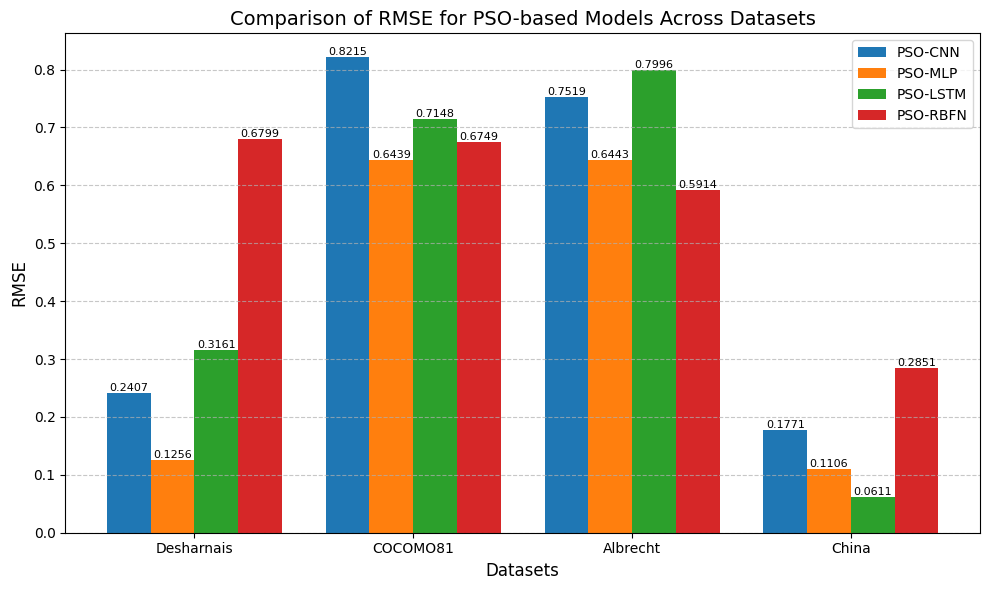

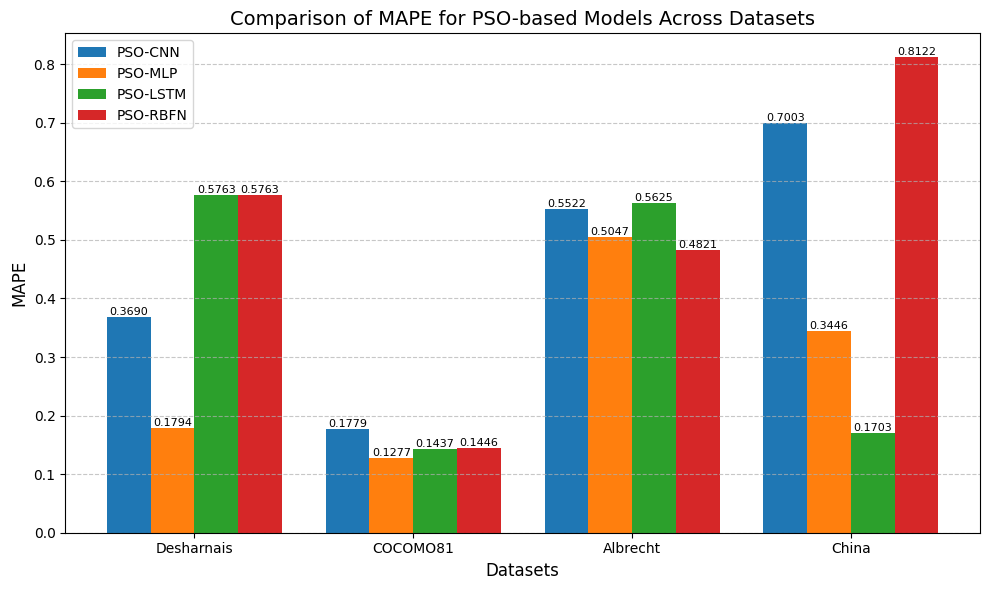

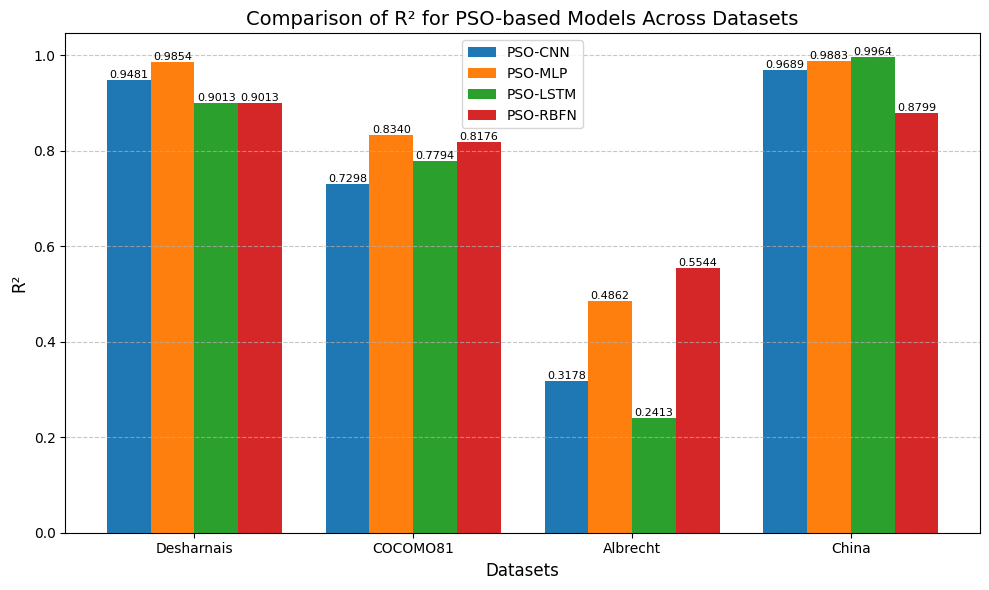

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu
datasets = ['Desharnais', 'COCOMO81', 'Albrecht', 'China']
models = ['PSO-CNN', 'PSO-MLP', 'PSO-LSTM', 'PSO-RBFN']

# Dữ liệu RMSE
rmse_data = {
    'PSO-CNN':  [0.2407, 0.8215, 0.7519, 0.1771],
    'PSO-MLP':  [0.1256, 0.6439, 0.6443, 0.1106],
    'PSO-LSTM': [0.3161, 0.7148, 0.7996, 0.0611],
    'PSO-RBFN': [0.6799, 0.6749, 0.5914, 0.2851]
}

# Dữ liệu MAPE (chuyển từ % sang số thập phân)
mape_data = {
    'PSO-CNN':  [36.90/100, 17.79/100, 55.22/100, 70.03/100],
    'PSO-MLP':  [17.94/100, 12.77/100, 50.47/100, 34.46/100],
    'PSO-LSTM': [57.63/100, 14.37/100, 56.25/100, 17.03/100],
    'PSO-RBFN': [57.63/100, 14.46/100, 48.21/100, 81.22/100]
}

# Dữ liệu R²
r2_data = {
    'PSO-CNN':  [0.9481, 0.7298, 0.3178, 0.9689],
    'PSO-MLP':  [0.9854, 0.8340, 0.4862, 0.9883],
    'PSO-LSTM': [0.9013, 0.7794, 0.2413, 0.9964],
    'PSO-RBFN': [0.9013, 0.8176, 0.5544, 0.8799]
}

# Tạo DataFrame
df_rmse = pd.DataFrame(rmse_data, index=datasets)
df_mape = pd.DataFrame(mape_data, index=datasets)
df_r2 = pd.DataFrame(r2_data, index=datasets)

# Hàm vẽ biểu đồ cột nhóm
def plot_grouped_bar(metric_data, metric_name, ylabel, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(datasets))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Vẽ từng mô hình
    for i, model in enumerate(models):
        bars = ax.bar(index + i*bar_width, metric_data[model], bar_width, label=model, color=colors[i])
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', 
                    ha='center', va='bottom', fontsize=8)

    # Thiết lập biểu đồ
    ax.set_xlabel('Datasets', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(f'Comparison of {metric_name} for PSO-based Models Across Datasets', fontsize=14)
    ax.set_xticks(index + bar_width * 1.5)
    ax.set_xticklabels(datasets, fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Vẽ biểu đồ cho RMSE
plot_grouped_bar(df_rmse, 'RMSE', 'RMSE', 'rmse_comparison.png')

# Vẽ biểu đồ cho MAPE
plot_grouped_bar(df_mape, 'MAPE', 'MAPE', 'mape_comparison.png')

# Vẽ biểu đồ cho R²
plot_grouped_bar(df_r2, 'R²', 'R²', 'r2_comparison.png')